# RAP in the UKBB

# Goals

- Understand what is RAP
- Get familiar with the interface
- Use RAP for research  - MWE
- Learn about the costs associated with RAP

## Understanding what is RAP?

This platform allows researchers to access the UK Biobank database containing phenotype and genotype data on the cloud (Amazon Web Services - AWS)

The phenotype data consists of ~40K fields that sum up to the genotype data, constitutes a very large database

### Who can use RAP?

Only approved UKB researchers that have a AMS account.

### What do you need to create an account in RAP?

AMS account and UKB access application ID

### Benefits of RAP

1. Allows to work with huge amounts of data -- make easy to use complex queries
2. Security and compliance with regulations
3. Integrates all kinds of data (e.g Phenotype, Genetic, Imaging, Accelerometer)

### Different ways to interact with RAP

1. UI -  Cohort Browser
2. Apps - Swiss Army Knife
3. JupyterLab
4. Spark JupyterLab

### Cloud-based analysis

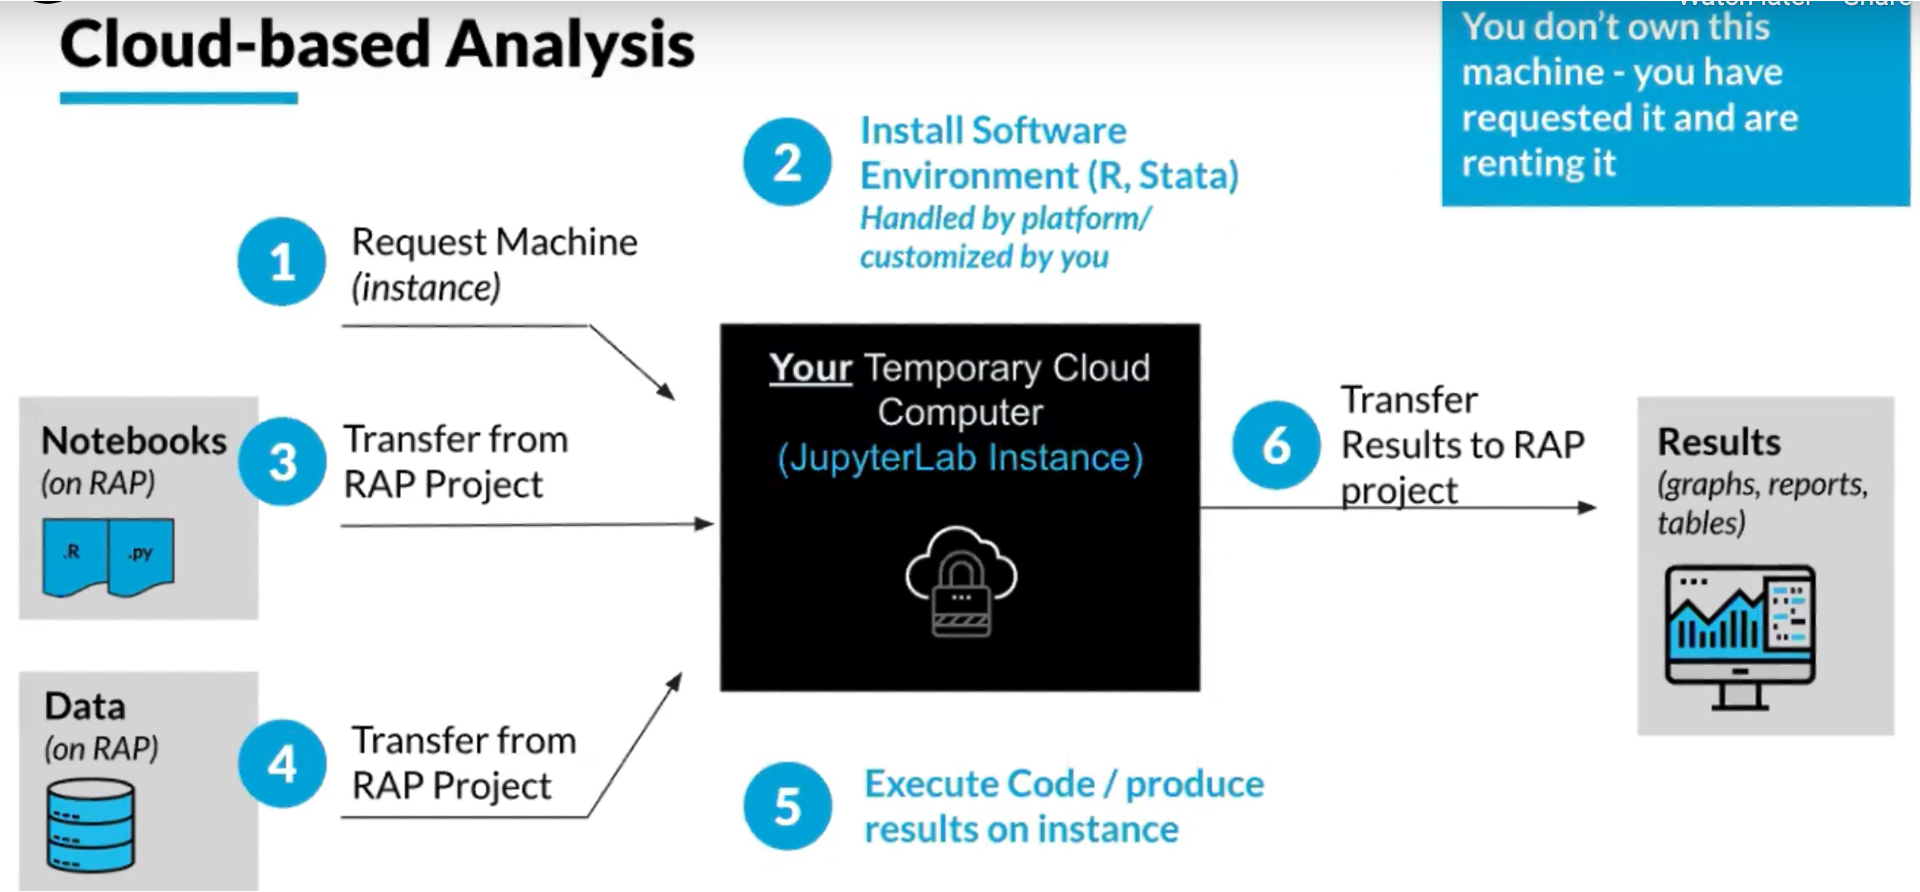

### Starting to use RAP

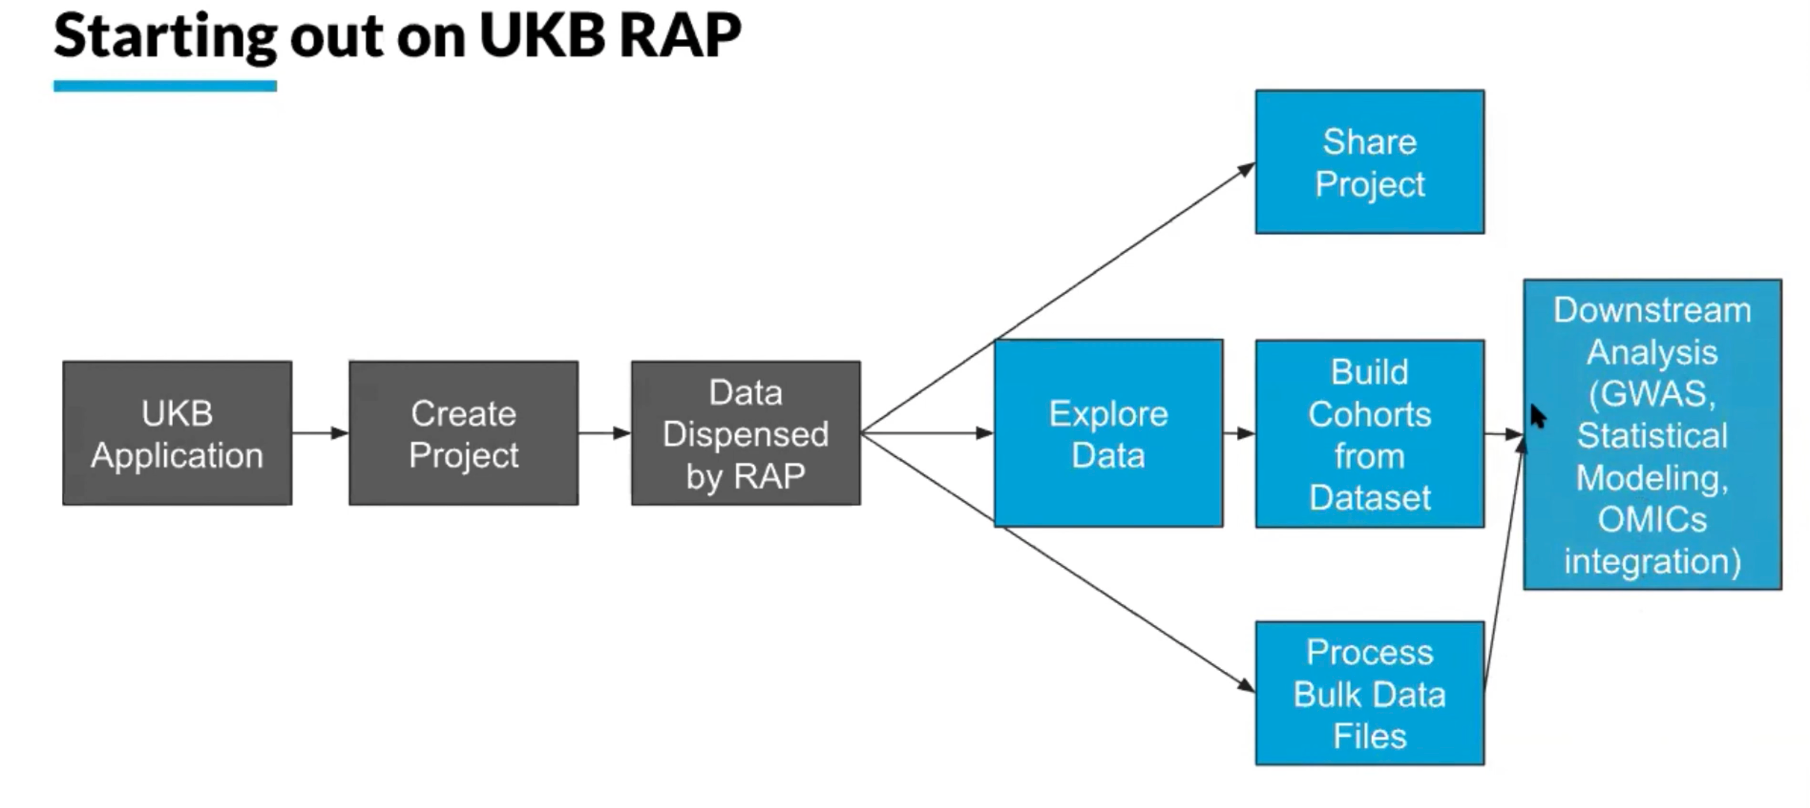


## Get familiar with the interface

### How the interface looks like
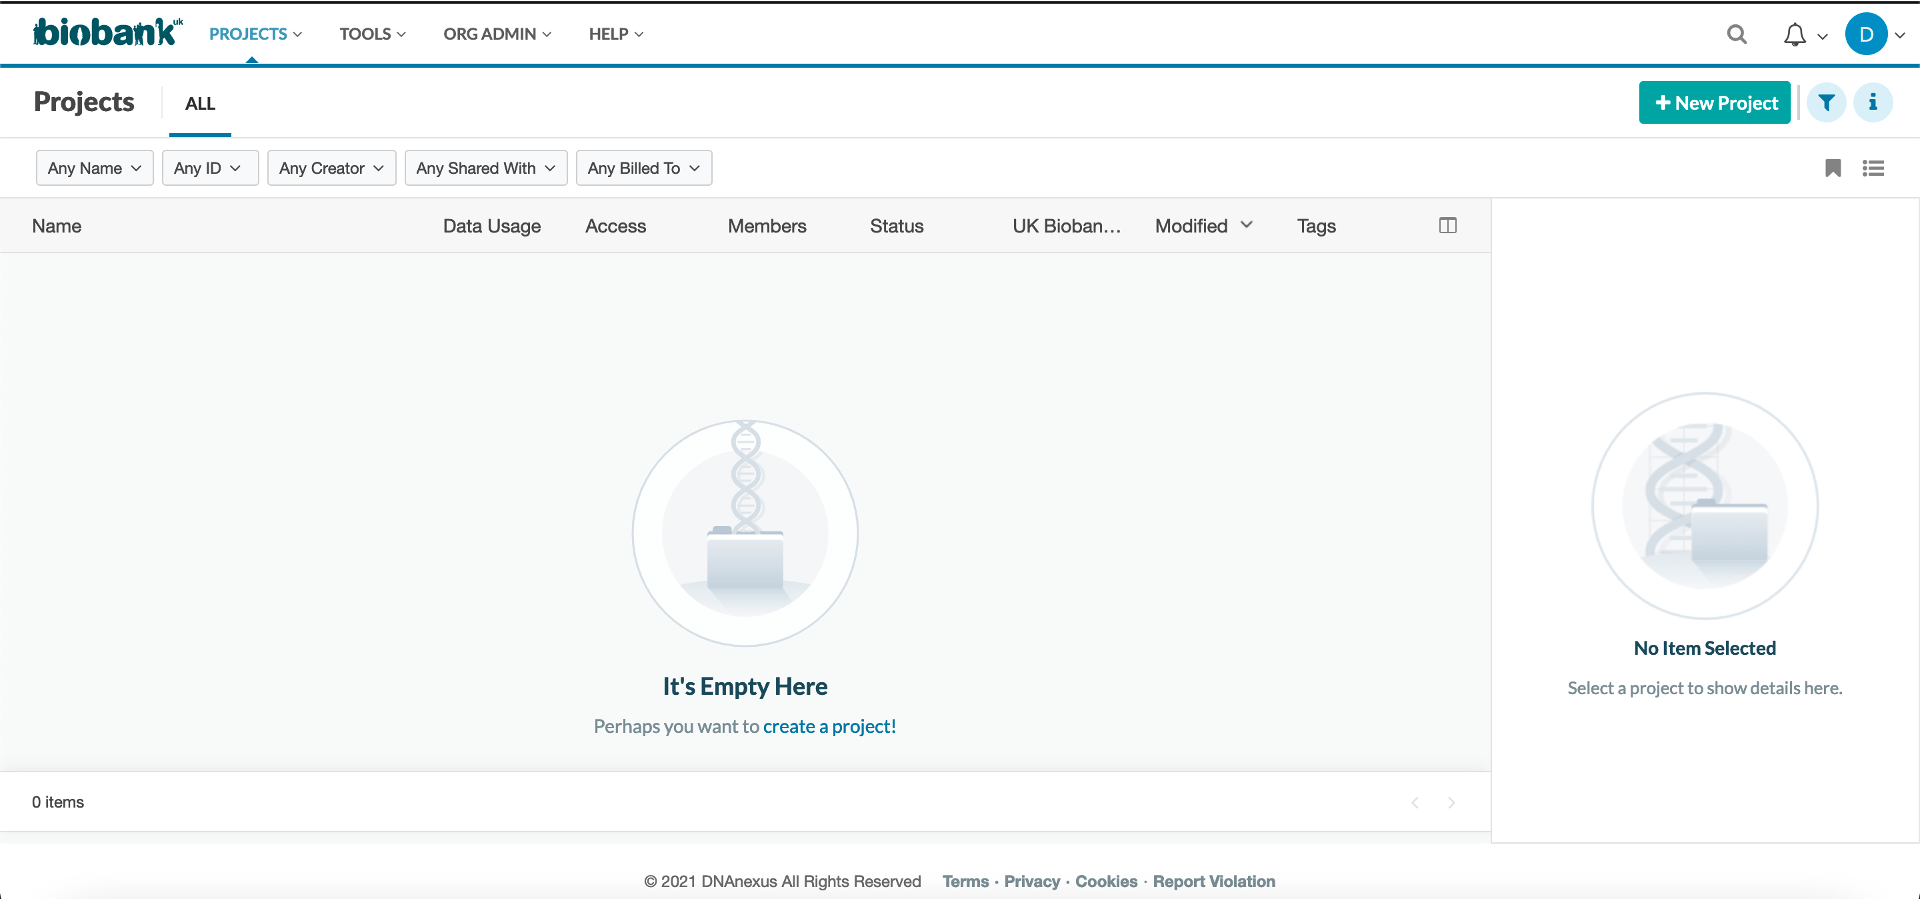

### Creating a project
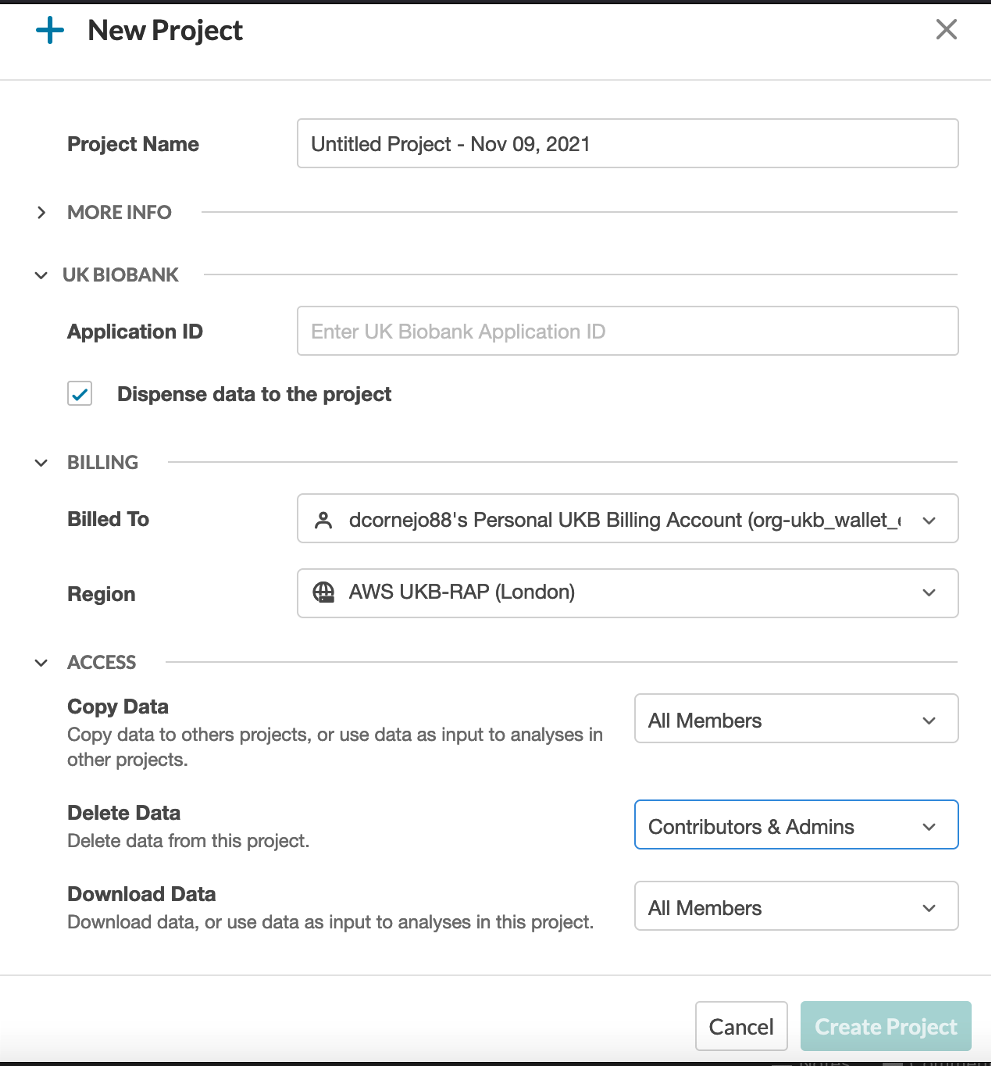

### Accessing your data
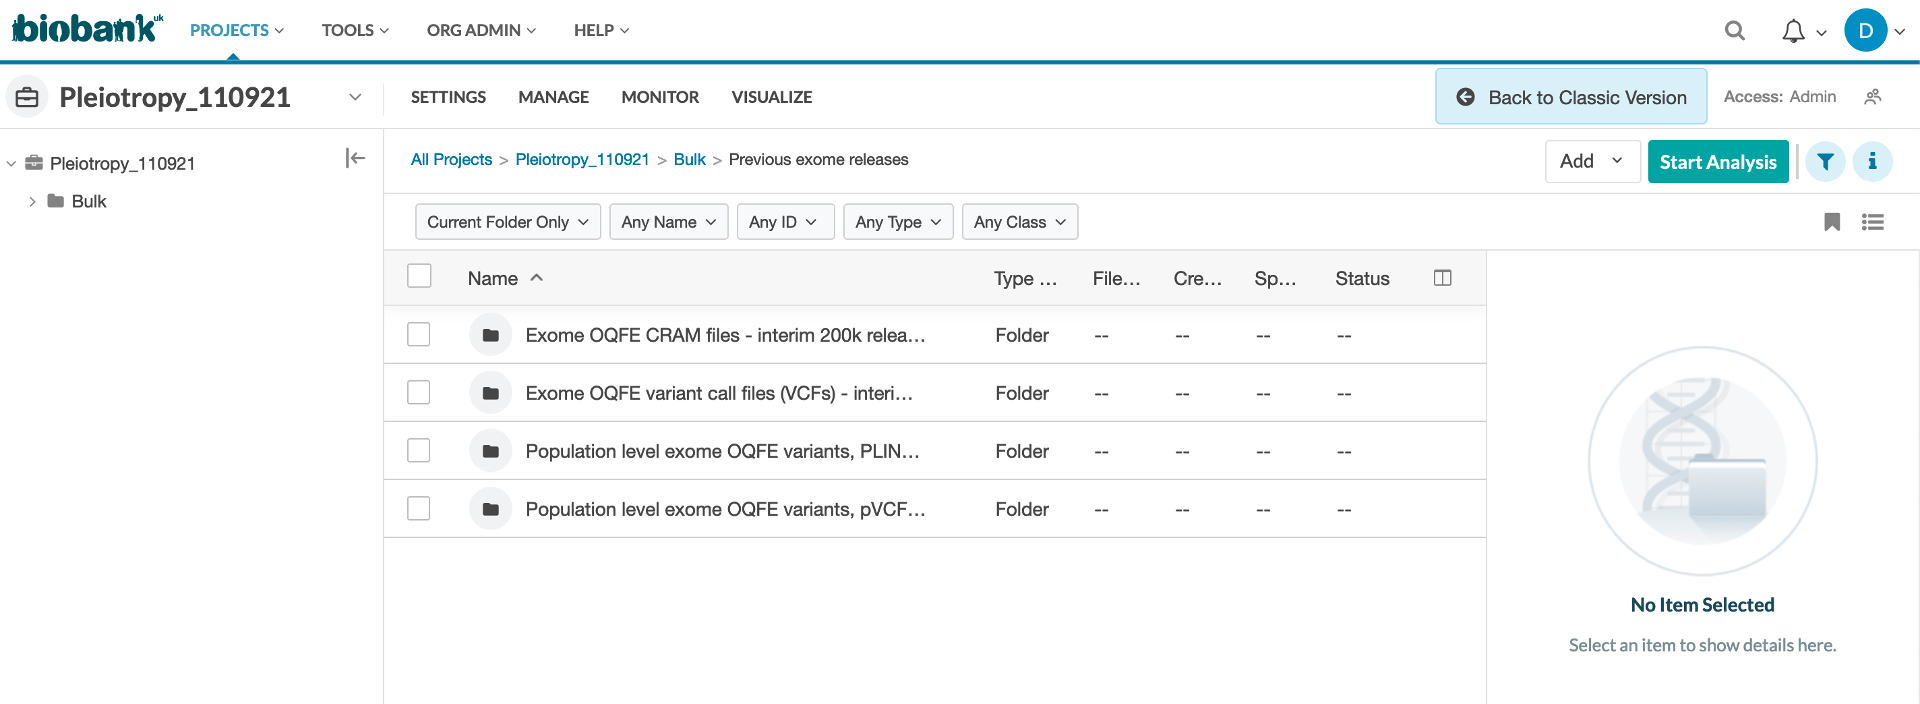

## JupyterLab (single node)

- Use to analyze cohort data : needs to be extracted beforehand with the cohort browser or with dxdata/Spark
- Cheaper than Spark


## Spark JupyterLab (multiple nodes)

- Conduct data science in a parallelized/distributed environment
    - Access phenotypic data using SQL
    - Do complex filtering
    - Derive phenotypes (new columns) and transform data
- Machine learning (MLlib) or specialized analyses (HAIL/GLOW)


### Toy example on how to use Spark Jupyter lab on RAP to extract phenotype data

### Aim

Create a phenotype file using UKB dataset

### What do we need beforehand?

1. Application ID (we will learn how to find this in the prologue section)
2. A list of field names that we want to retrieve

Note: we have the option of creating cohorts using the cohort browser and then perform all of the operations on that specific cohort

### How do we extract information?

1. Run the prologue
2. Acces the dataset estructure using `dxdata.load_dataset()` as dataset
3. Extract the entity of interest `(participant)` from the `dataset`
4. List all the desired field names (including *instances* and *arrays*)
5. Retrieve the data as a Spark DataFrame using `.retrieve_fields()`
6. Convert the data to a Pandas DataFrame using `toPandas()`, further analyze the data
7. Save the results as a `.csv` file to JupyterLab Storage
8. Upload results to the UKB project folder (very important step, if you fail to do this you will lose you data after the session is over)


### 1. Prologue

This prologue has been created for consistency across notebooks, and to improve notebook portability across projects.

It is recommened to use this prologue at the begging of each Jupyter Notebook that needs to pull the phenotype info from either the full dataset or a cohort

First thing is to load up necessary python packages

In [ ]:
## Import packages
import pyspark
import dxpy
import dxdata
import pandas as pd

Be careful running the following cell only once. Spark gets confused if you initialize it multiple times, it does not like creating multiple Spark session/contexts

In case you do that by accident, there's a fix. If you accidentally run this code block twice go to **Kernel >> Restart Kernel** and start executing the code from the beginning

In [ ]:
# Spark initialization (Done only once; do not rerun this cell unless you select Kernel -> Restart kernel).
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)

### **Detect dataset ID which is located in the Project root directory**

This bit of code will automatically identify the dataset ID and retrieve it 

In [ ]:
# Automatically discover dispensed database name and dataset id
dispensed_database = dxpy.find_one_data_object(
    classname="database", 
    name="app*", 
    folder="/", 
    name_mode="glob", 
    describe=True)
dispensed_database_name = dispensed_database["describe"]["name"]

dispensed_dataset = dxpy.find_one_data_object(
    typename="Dataset", 
    name="app*.dataset", 
    folder="/", 
    name_mode="glob")
dispensed_dataset_id = dispensed_dataset["id"]

### 2. Access dataset

We'll use `dxdata.load_dataset()` to load the dataset structure and then we'll be able to learn about UKB entities (virtual tables) and acces fields within this entities.

**Load dataset into Spark**

In [ ]:
dispensed_dataset_id

In [ ]:
dataset = dxdata.load_dataset(id=dispensed_dataset_id)

Note: UKB entities are virtual tables linked to one another

The main entity in the UKB is participant and corresponds to the most pheno fields in the UKB data. Other entities are for example linked health care records. 

Entities that start with "hesin" is for hospital records, "gp" is for GP records 

In [ ]:
dataset.entities

### 3. Access main participant entity

We can access `participant` by extracting it from the `dataset`

In [ ]:
participant = dataset["participant"]

### 4. Load Cohort

If you have a cohort you can load it here by using `dxdata.load_cohort()`. You can also extract the Spark SQL that was used to build it.

In [ ]:
cohort = dxdata.load_cohort("/cohorts/my_cohort")

In [ ]:
cohort.sql

### 5. Selecting the fields we want

This is if you know exactly the coding of the fields that you want, You can search in the UKB showcase and understad the coding a bit more. 

#### Constructing field names, given UKB showcase field id, instance id, and array id

For the main participant data, the Platform uses field names with the following convention:

|Type of field|Syntax for field name|Example|
|:------------|---------------------|-------|
|Neither instanced nor arrayed|`p<FIELD-ID>`|`p31`|
|Instanced but not arrayed|`p<FIELD-ID>_i<INSTANCE-ID>`|`p40005_i0`|
|Arrayed but not instanced|`p<FIELD-ID>_a<ARRAY-ID>`|`p41262_a0`|
|Instanced and arrayed|`p<FIELD-ID>_i<INSTANCE-ID>_a<ARRAY-ID>`|`p93_i0_a0`|

Lastly, the participant id field itself (EID) is named `eid`

If you know exactly the field names you want to work with, put them in a string array (we will see later how to use that):

In [ ]:
fields = ['eid', 'p31', 'p22001']

#### Looking up fields, given UKB showcase field id

If you know the field id but you are not sure if it is instanced or arrayed, and want to grab all instances/arrays (if any), use these:

In [ ]:
# Returns all field objects for a given UKB showcase field id

def fields_for_id(field_id):
    from distutils.version import LooseVersion
    field_id = str(field_id)
    fields = participant.find_fields(name_regex=r'^p{}(_i\d+)?(_a\d+)?$'.format(field_id))
    return sorted(fields, key=lambda f: LooseVersion(f.name))

# Returns all field names for a given UKB showcase field id

def field_names_for_id(field_id):
    return [f.name for f in fields_for_id(field_id)]

### Examples:

In [ ]:
# Participant sex
field_names_for_id("31")

In [ ]:
# Age when attending assessment centre has multiple instances (visits) 
field_names_for_id("21003")

In [ ]:
# Hearing aid user has multiple instances (visits)
field_names_for_id("3393")

In [ ]:
# Pulse rate has multiple instances and array indices (measured twice in each visit)
field_names_for_id("102")

### 6. Extracting the fields to Spark DataFrame

In [ ]:
df = participant.retrieve_fields(names=field_names, engine=dxdata.connect())

# Swiss army Knife

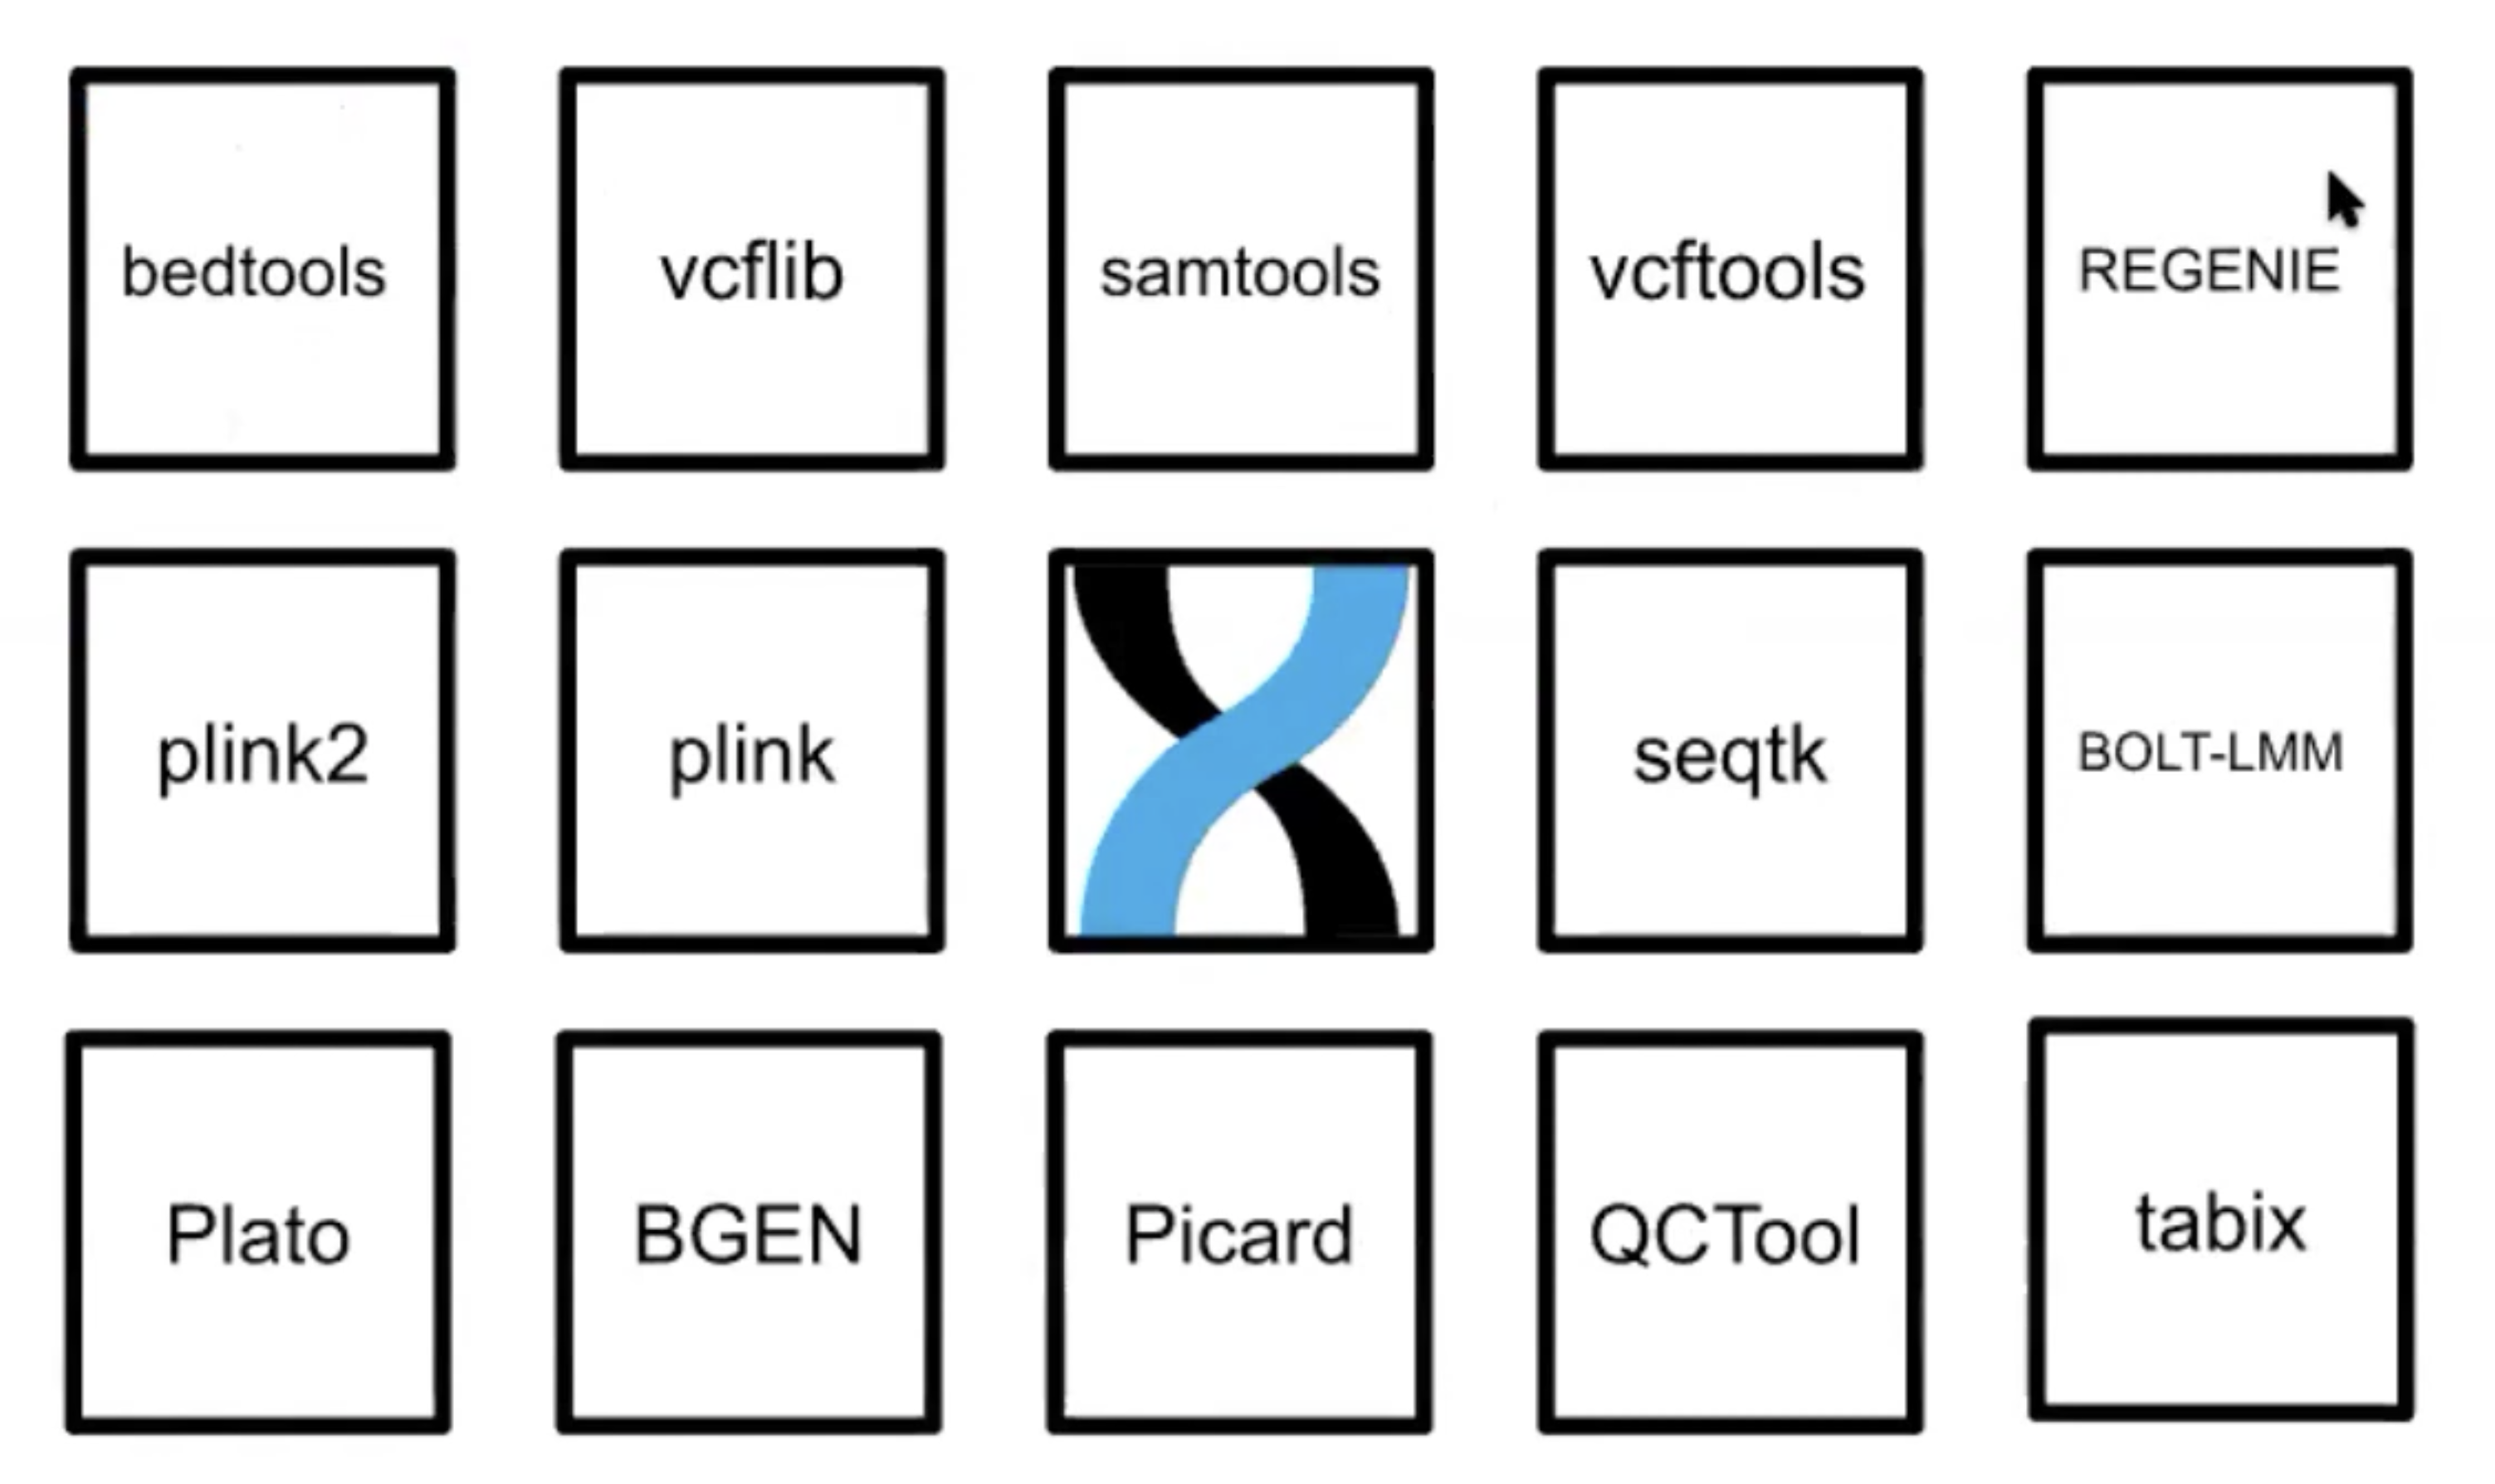

# CLI within RAP

Install dx toolkit

`pip3 install dxpy`

In [ ]:
# Use username and password from RAP
dx login
dx whoami